In [15]:
## ASE imports
from ase import Atoms, units 
from ase.constraints import ExpCellFilter, StrainFilter, FixAtoms
from ase.optimize import LBFGS
from ase.io import Trajectory, write, read
from ase.io.vasp import read_vasp, write_vasp
from ase.build import bulk, surface, molecule
from ase.md.nvtberendsen import NVTBerendsen
from ase.md import MDLogger
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary

## Pymatgen imports
from pymatgen.core import Structure
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor

## Visualization and data processing
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from time import perf_counter
import shutil

## PFP specific
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorMethodType


def visual2(structure,title,  max_size=(100, 100), rotation='15z,-90x',celloff=True):
    def calculate_stretch_factor(cell):
        x_length = cell[0][0]
        y_length = cell[1][1]

        # Avoid division by zero
        if y_length == 0:
            return 1.0

        stretch_y = y_length / x_length
        return stretch_y
    stretch_y = calculate_stretch_factor(structure.cell)
    temp=structure.copy()
    if celloff==True:
      temp.cell = None
    # Visualize the structure
    renderer = write('./temp.pov', temp, rotation=rotation)
    renderer.render()
    image_path = f'./temp.png'
    img = Image.open(image_path)
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    img.info['dpi'] = 2000
    display(img)
    destination = './output/'
    files = ['./temp.ini', './temp.pov', './temp.png']
    os.makedirs(destination, exist_ok=True)
    for file in files:
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))
        shutil.move(file, destination)
    original_image_path = os.path.join(destination, 'temp.png')
    new_image_path = os.path.join(destination, f'{title}.png')
    os.rename(original_image_path, new_image_path)
    
#############################Calculator setting###################################
calc_mode="CRYSTAL" # including +U correction
model_version="v4.0.0"  # the latest model version
method_type=EstimatorMethodType.PFVM
estimator = Estimator(calc_mode=calc_mode, model_version=model_version, method_type=method_type)
calculator = ASECalculator(estimator)
##################################################################################

def get_opt_energy(atoms, fmax=0.05, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

In [16]:
ceo2 = read_vasp("../0_input/ceo2_bulk")
ceo2.calc = calculator
mol = molecule("O2")
mol.calc = calculator
E_mol = get_opt_energy(mol)
E_bulk = get_opt_energy(ceo2)
print(E_bulk,len(ceo2))

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 07:55:23       -5.920262*       0.7392
LBFGS:    1 07:55:23       -5.920360*       0.7693
['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


NameError: name 'ceo2' is not defined

In [4]:


def fix_atoms(atoms):
    temp=atoms.copy()
    ce_positions = np.array([temp.position for temp in temp if temp.symbol == 'Ce'])
    ce_median_z = np.median(ce_positions[:, 2])
    mask = temp.positions[:, 2] < ce_median_z
    c = FixAtoms(mask=mask)
    temp.set_constraint(c)
    num_constrained_atoms = np.sum(mask)
    print("how many fixed atoms:", num_constrained_atoms, "out of", temp.get_global_number_of_atoms())
    
    return temp
def print_slab_info(atoms):
    # Calculate and print the size
    size_x = round(atoms.cell[0, 0], 3)
    size_y = round(atoms.cell[1, 1], 3)
    ce_positions = np.array([atom.position for atom in atoms if atom.symbol == 'Ce'])
    ce_min_z, ce_max_z = np.min(ce_positions[:, 2]), np.max(ce_positions[:, 2])
    size_z = round(ce_max_z-ce_min_z,3)
    print(f"length and width : {size_x} A x {size_y} x {size_z}  A")
    print(f"N_atoms: {len(atoms)}")
    symbols = atoms.get_chemical_symbols()
    element_counts = Counter(symbols)
    element_counts_line = ', '.join(f"{element}: {count}" for element, count in element_counts.items())
    print(f"Composition: {element_counts_line}")
    print("===============================")

def generate_slab(bulk, miller_index, supercell_dimensions,thick,fixoff=False):
    bulk_temp=bulk.copy()
    slab_gen = SlabGenerator(
        initial_structure=AseAtomsAdaptor.get_structure(bulk_temp),
        miller_index=miller_index,
        min_slab_size=thick,
        min_vacuum_size=40.0,
        lll_reduce=False,
        center_slab=True,
        primitive=True,
        max_normal_search=1,
    )
    
    slabs = slab_gen.get_slabs(tol=0.3, bonds=None, max_broken_bonds=0, symmetrize=False)
    slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in slabs]
    print('N termination:',len(slab_atoms_list))
    slab = slab_atoms_list[0].copy()
    slab = slab * supercell_dimensions
    
    # Shift `slab` to the bottom of the cell
    min_pos_z = np.min(slab.positions, axis=0)[2]
    slab.set_positions(slab.positions - [0, 0, min_pos_z])
    temp = slab.copy()
    if fixoff==False:
        temp = fix_atoms(temp)
        
    return temp


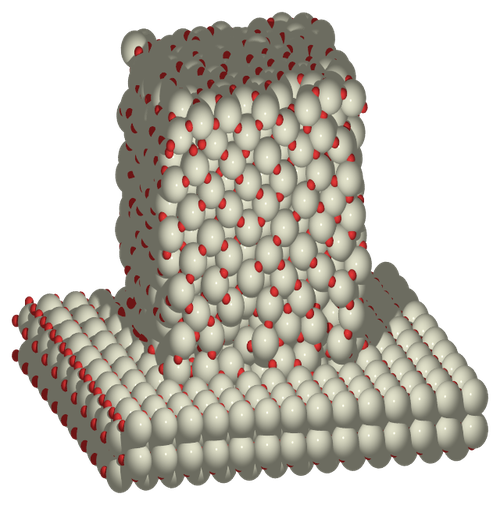

In [5]:
structure = Trajectory("../1_structure_gen/output/best_mace_structure.traj")
visual2(structure[0], f'test', (500, 500), rotation='15z,-75x', celloff=True)

In [6]:
def get_nth_ce_atom(atoms, n):
    # Extract positions of Ce atoms along the z-axis
    all_positions = np.array([atom.position[2] for atom in atoms ])
    all_positions_sorted = np.sort(all_positions)
    print("total atoms =", len(all_positions))
    if len(all_positions_sorted) >= n:
        desired_position = all_positions_sorted[n-1]  # Indexing starts from 0
        # Find the index of the Ce atom with the desired position
        index = np.where(all_positions == desired_position)[0][0]
        return index
    else:
        print(f"There are fewer than {n} Ce atoms in the system.")
        return None

def O2_detect_and_delete(atoms, cutoff=2):
    o_indices = np.array([atom.index for atom in atoms if atom.symbol == 'O' ])
    ce_indices = np.array([atom.index for atom in atoms if atom.symbol == 'Ce' ])

    o2_to_delete=[]
    for o_index in o_indices:
        ref = atoms.positions[o_index]
        neighbor_o_indices = np.where(np.all(np.abs(atoms.positions[ce_indices] - ref) < cutoff, axis=1))[0]
        neighbor_positions = [atoms.positions[ce_index] for ce_index in ce_indices[neighbor_o_indices]]
        
        # If distance is within 1.6, add the index to o2_to_delete
        if  len(neighbor_o_indices) == 0:
            o2_to_delete.append(o_index)
            #break  # No need to continue checking once one close O2 is found
    print(o2_to_delete)

    return o2_to_delete
o2_removed_atoms=O2_detect_and_delete(structure[0], cutoff=2.5)
del structure[0][o2_removed_atoms]

In [32]:
import numpy as np

def ovac_tot_gen(Atoms):
    neighbor_o_info_dict = {}
    ce_indices = np.where(Atoms.symbols == 'Ce')[0]
    o_indices = np.where(Atoms.symbols == 'O')[0]
    traj=[]
    for i,o_index in enumerate(o_indices):
            ref = Atoms.positions[o_index]
            temp = Atoms.copy()
            del temp[o_index]
            neighbor_o_info_dict[o_index] = {
                'deleted_O_index': o_index,
                'deleted_O_positions': ref,
                'Ovac_atoms' : temp,
            }
            traj.append(temp)
    
    return neighbor_o_info_dict,traj


neighbor_o_info_dict,traj = ovac_tot_gen(o2_removed_atoms)



'# Print the dictionary\nfor o_index, info in neighbor_o_info_dict.items():\n    print(f"Oxygen Index: {o_index}")\n    print(f"Neighbor Indices: {len(info[\'indices\'])}")\n    print(f"O Positions: {info[\'positions\']}")'

In [18]:
get_opt_energy(o2_removed_atoms,0.05)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:50:42   -24941.314415*       0.1905
LBFGS:    1 05:50:43   -24941.316532*       0.1341
LBFGS:    2 05:50:43   -24941.323872*       0.0711
LBFGS:    3 05:50:43   -24941.325608*       0.0692
LBFGS:    4 05:50:44   -24941.329760*       0.0662
LBFGS:    5 05:50:44   -24941.332314*       0.0632
LBFGS:    6 05:50:44   -24941.334633*       0.0623
LBFGS:    7 05:50:45   -24941.336975*       0.0724
LBFGS:    8 05:50:45   -24941.339979*       0.0665
LBFGS:    9 05:50:45   -24941.342872*       0.0722
LBFGS:   10 05:50:46   -24941.345311*       0.0813
LBFGS:   11 05:50:46   -24941.348056*       0.0867
LBFGS:   12 05:50:47   -24941.350824*       0.0872
LBFGS:   13 05:50:47   -24941.354173*       0.0807
LBFGS:   14 05:50:47   -24941.357724*       0.0685
LBFGS:   15 05:50:47   -24941.361554*       0.0805
LBFGS:   16 05:50:48   -24941.365874*       0.0883
LBFGS:   17 05:50:48   -24941.3704

-24695.24388565614

In [ ]:
post_str_list=[]
for o_index, info in neighbor_o_info_dict.items():
    temp=info['Ovac_atoms'].copy()
    energy=get_opt_energy(temp,0.05)
    info['Ovac_atoms']= temp
    info['energy']= energy
    post_str_list.append(temp)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:56:33   -24935.281638*       0.7110
LBFGS:    1 05:56:34   -24935.321893*       0.5600
LBFGS:    2 05:56:34   -24935.397138*       0.3683
LBFGS:    3 05:56:34   -24935.409980*       0.3208
LBFGS:    4 05:56:34   -24935.419715*       0.0729
LBFGS:    5 05:56:35   -24935.421837*       0.0728
LBFGS:    6 05:56:35   -24935.426207*       0.1185
LBFGS:    7 05:56:36   -24935.428530*       0.1251
LBFGS:    8 05:56:36   -24935.431255*       0.0793
LBFGS:    9 05:56:36   -24935.433659*       0.0726
LBFGS:   10 05:56:37   -24935.439597*       0.0711
LBFGS:   11 05:56:37   -24935.441117*       0.0535
LBFGS:   12 05:56:37   -24935.438161*       0.0414
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:56:37   -24934.382467*       2.7570
LBFGS:    1 05:56:38   -24934.854140*       2.2511
LBFGS:    2 05:56:38   -24935.796456*

In [ ]:
import pickle

file_name = 'output/fin_ovac_tot_dict.pkl'

with open(file_name, 'wb') as f:
    pickle.dump(neighbor_o_info_dict, f)
